In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import scipy.misc as misc

%matplotlib inline


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
DIRECTORY = '/Users/xuehan.xiong/Google Drive/datasets/selfies_segmentation'
TF_RECORDS = 'portrait_segmentation.tfrecords'
IMAGE_SIZE = 128
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 7996

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image_raw': tf.FixedLenFeature([],tf.string),
            'label': tf.FixedLenFeature([],tf.string),
            'height': tf.FixedLenFeature([],tf.int64),
            'width': tf.FixedLenFeature([],tf.int64),
            'depth': tf.FixedLenFeature([],tf.int64),
        })
    height = tf.cast(features['height'],tf.int32)
    width = tf.cast(features['width'],tf.int32)
    depth = tf.cast(features['depth'],tf.int32)
    
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    image = tf.reshape(image, tf.pack([height, width, depth]))

    label = tf.decode_raw(features['label'], tf.uint8)
    label = tf.reshape(label, tf.pack([height, width, 1]))
    return image,label

In [12]:
def distorted_inputs(filenames, batch_size):
    """Construct distorted input for CIFAR training using the Reader ops.
    Args:
        filename: Path to the tensorflow record file.
        batch_size: Number of images per batch.
    Returns:
        images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
        labels: Labels. 3D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE] size.
    """
    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames)

    # Read examples from files in the filename queue.
    # Both image and label are 3-D tensor
    image,label = read_and_decode(filename_queue)
    image_label = tf.concat(2,[image,label])
    image_label = tf.cast(image_label, tf.float32)

    height = IMAGE_SIZE
    width = IMAGE_SIZE
    # Image processing for training the network. Note the many random
    # distortions applied to the image.

    # Randomly crop a [height, width] section of the image.
    distorted_image_label = tf.random_crop(image_label, [height, width, 4])
    # Randomly flip the image horizontally.
    distorted_image_label = tf.image.random_flip_left_right(distorted_image_label)
    distorted_image = tf.slice(distorted_image_label,[0,0,0],[IMAGE_SIZE,IMAGE_SIZE,3])
    distorted_label = tf.slice(distorted_image_label,[0,0,3],[IMAGE_SIZE,IMAGE_SIZE,1])
    distorted_label = tf.squeeze(distorted_label)
    # Because these operations are not commutative, consider randomizing
    # the order their operation.
    #distorted_image = tf.image.random_brightness(distorted_image,
    #                                            max_delta=63)
    #distorted_image = tf.image.random_contrast(distorted_image,
    #                                            lower=0.2, upper=1.8)
    distorted_image = distorted_image * (1. / 255) - 0.5
    
    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                            min_fraction_of_examples_in_queue)
    print ('Filling queue with %d images before starting to train. '
            'This will take a few minutes.' % min_queue_examples)

    # Generate a batch of images and labels by building up a queue of examples.
    return _generate_image_and_label_batch(distorted_image, distorted_label,
                                            min_queue_examples, batch_size,
                                            shuffle=True)

In [13]:
def _generate_image_and_label_batch(image, label, min_queue_examples,
                                    batch_size, shuffle):
    """Construct a queued batch of images and labels.
    Args:
        image: 3-D Tensor of [height, width, 3] of type.float32.
        label: 2-D Tensor of [height, width]
        min_queue_examples: int32, minimum number of samples to retain
          in the queue that provides of batches of examples.
        batch_size: Number of images per batch.
        shuffle: boolean indicating whether to use a shuffling queue.
    Returns:
        images: Images. 4D tensor of [batch_size, height, width, 3] size.
        labels: Labels. 3D tensor of [batch_size, height, width] size.
    """
    # Create a queue that shuffles the examples, and then
    # read 'batch_size' images + labels from the example queue.
    num_preprocess_threads = 2
    if shuffle:
        images, labels = tf.train.shuffle_batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
    else:
        images, labels = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size)

    return images, labels


In [14]:
tf_file = os.path.join(DIRECTORY,TF_RECORDS)
images,labels = distorted_inputs([tf_file], 16)



Filling queue with 3198 images before starting to train. This will take a few minutes.


In [15]:
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
tf.train.start_queue_runners(sess=sess)


[<Thread(Thread-8, started daemon 123145568583680)>,
 <Thread(Thread-9, started daemon 123145572790272)>,
 <Thread(Thread-10, started daemon 123145576996864)>]

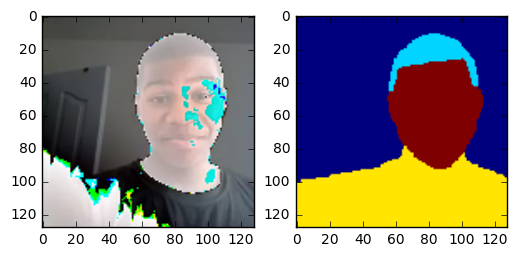

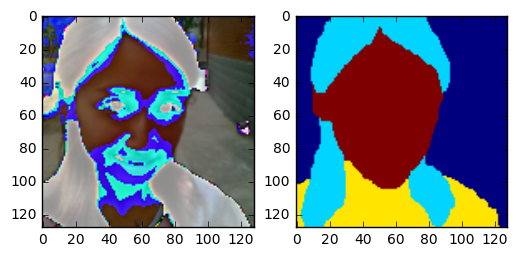

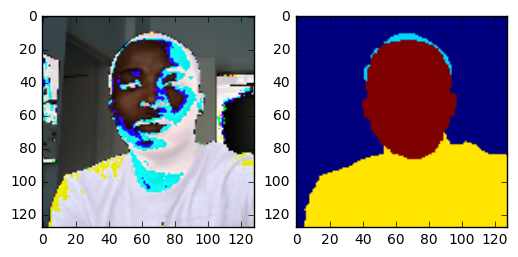

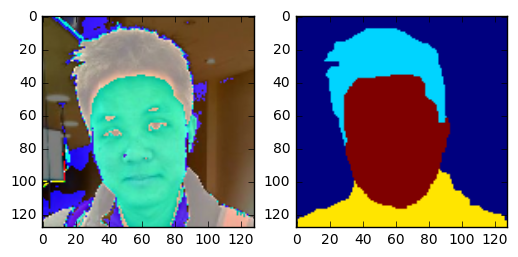

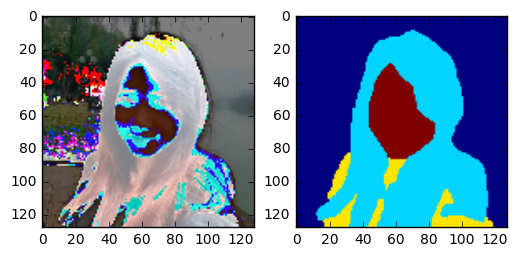

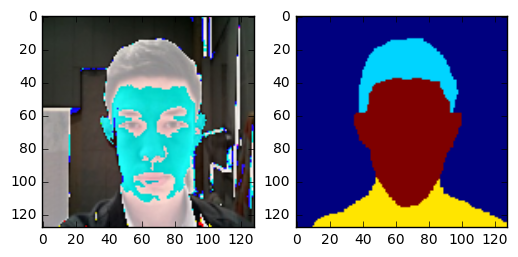

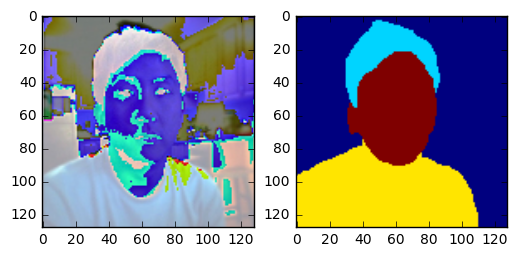

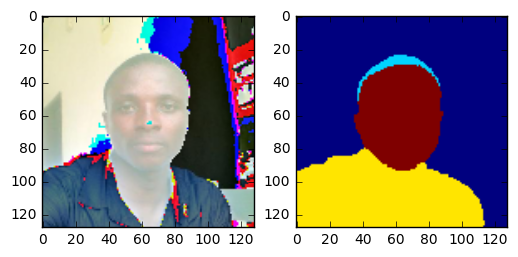

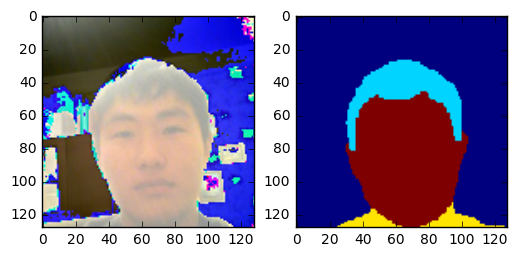

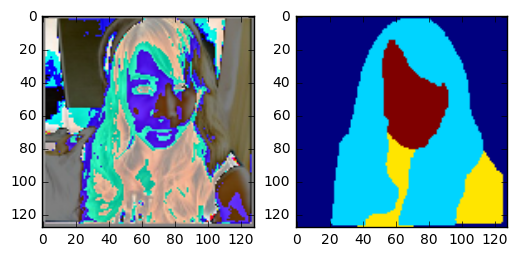

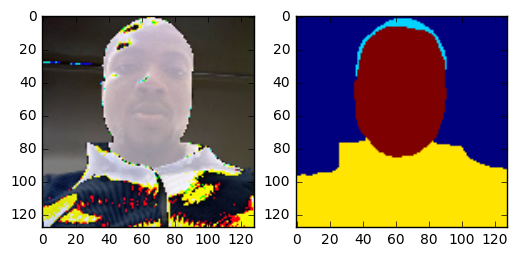

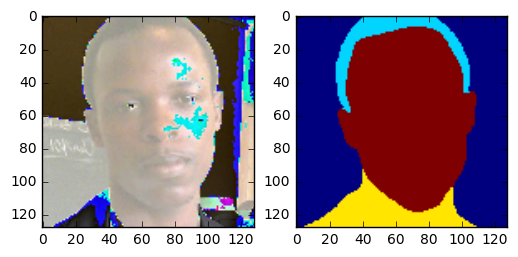

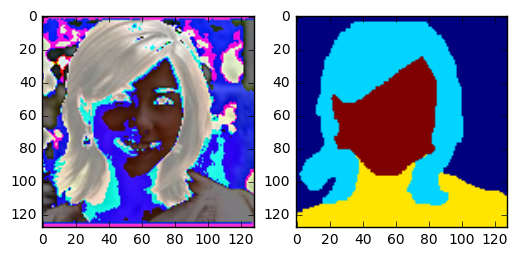

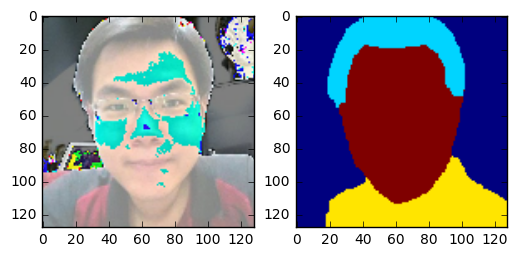

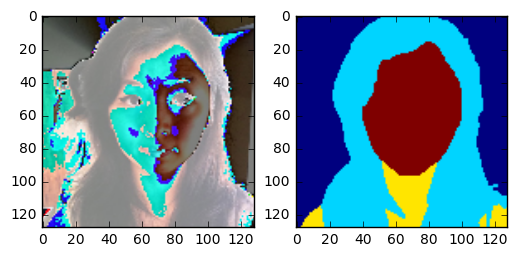

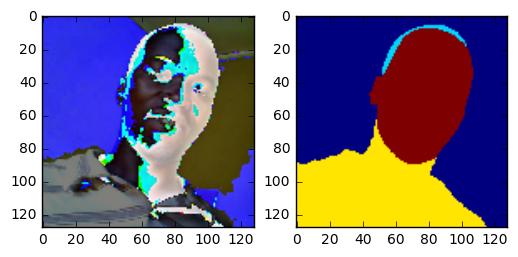

In [23]:
image_val,label_val = sess.run([images,labels])
for i in range(16):
    plt.subplot(121)
    plt.imshow(image_val[i,:,:,:])
    plt.subplot(122)
    plt.imshow(label_val[i,:,:])
    plt.show()
#image_val.set_shape([height_val,width_val,depth_val])
